Selecciona el archivo CSV desde tu PC


Saving SI_L07_SVM_DATASET.csv to SI_L07_SVM_DATASET (12).csv
Mapeo de continentes a etiquetas numericas:
Africa: 0
Asia: 1
Europe: 2
North America: 3
Oceania: 4
South America: 5


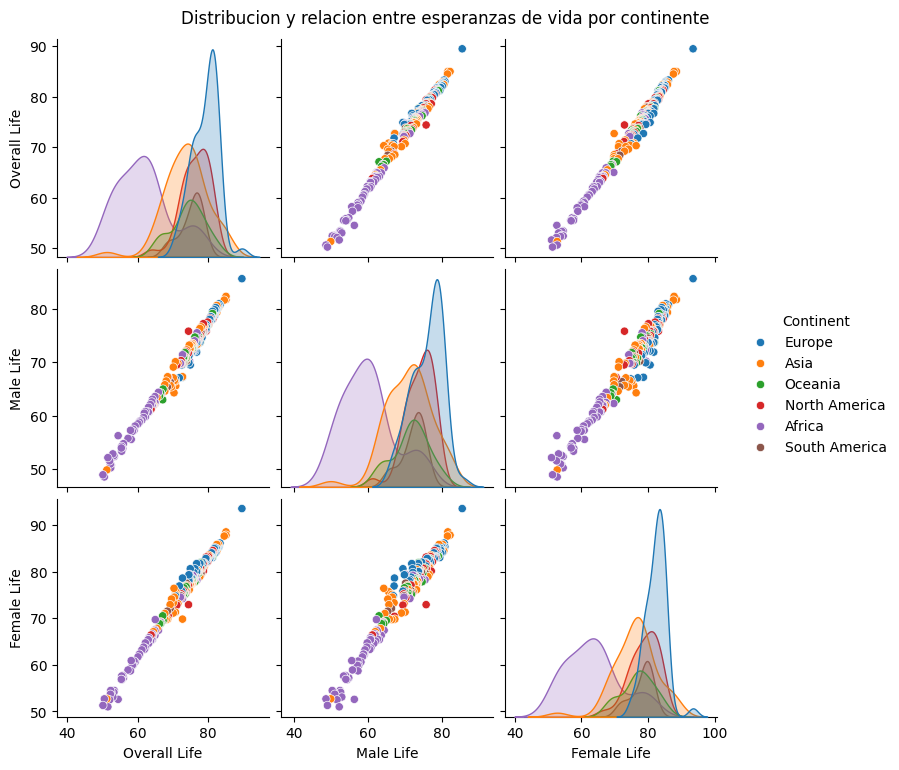


Precision del modelo: 0.48

Reporte de Clasificacion:
                precision    recall  f1-score   support

       Africa       1.00      0.88      0.94        17
         Asia       0.60      0.20      0.30        15
       Europe       0.53      0.60      0.56        15
North America       0.40      0.20      0.27        10
      Oceania       0.00      0.00      0.00         6
South America       0.15      0.75      0.25         4

     accuracy                           0.48        67
    macro avg       0.45      0.44      0.39        67
 weighted avg       0.58      0.48      0.49        67



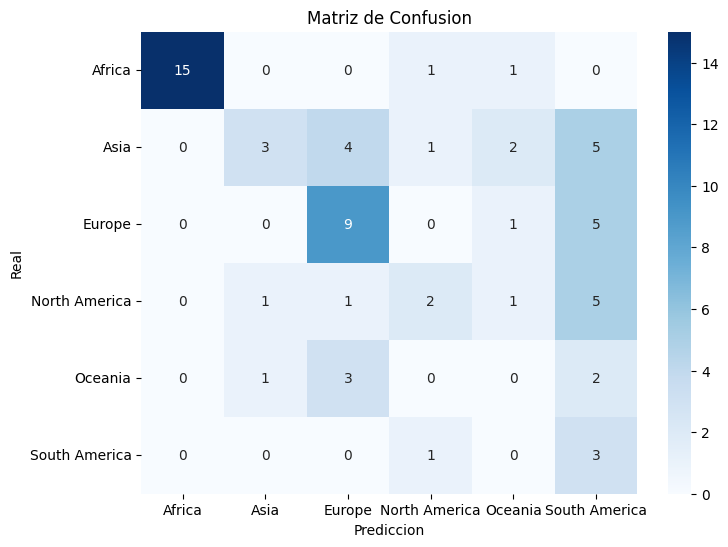


Promedio de esperanza de vida por continente (de mayor a menor):


,Overall Life,Male Life,Female Life
Continent,,,
Europe,79.019608,76.003922,82.237255
North America,76.273529,73.914706,78.738235
South America,75.042857,72.157143,77.992857
Oceania,74.230000,71.625000,76.915000
Asia,73.618367,71.046939,76.138776
Africa,61.800000,60.109091,63.583636


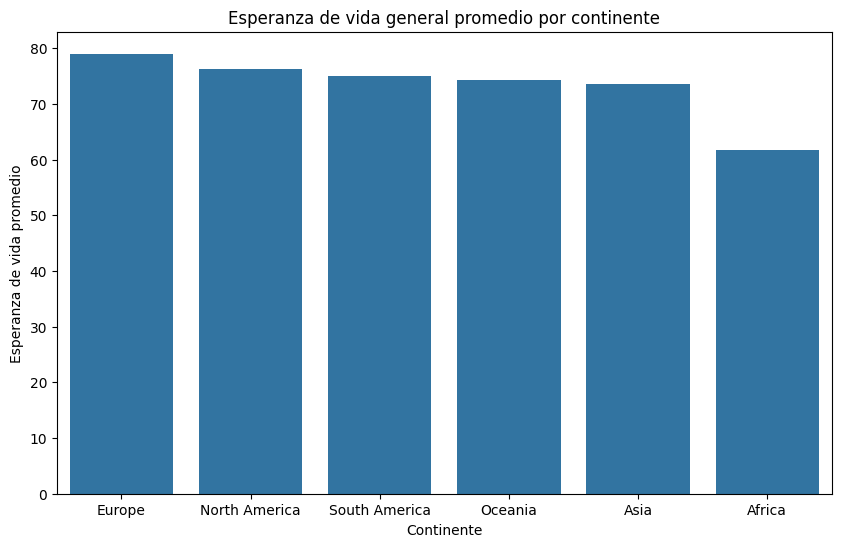

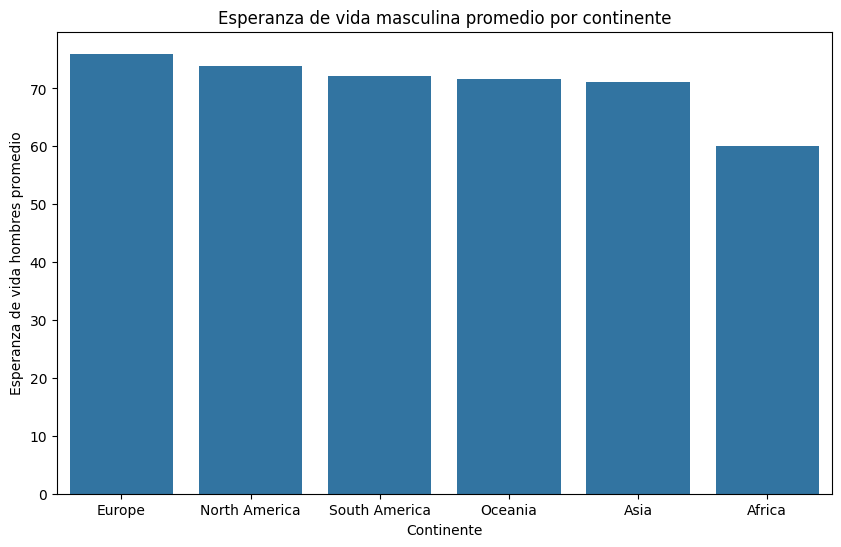

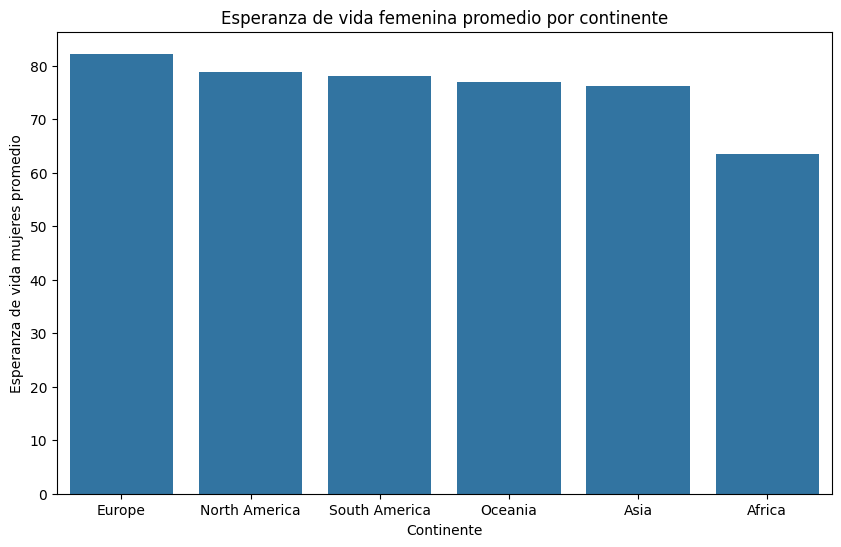


Coeficientes del modelo logistico (influencia aproximada):


,Overall Life,Male Life,Female Life
Africa,-0.851564,-0.400068,-0.904194
Asia,0.049659,0.323185,-0.857175
Europe,0.687339,-0.293010,1.830107
North America,0.241674,0.901488,-0.346582
Oceania,-0.116521,-0.328512,0.082247
South America,-0.010587,-0.203083,0.195596


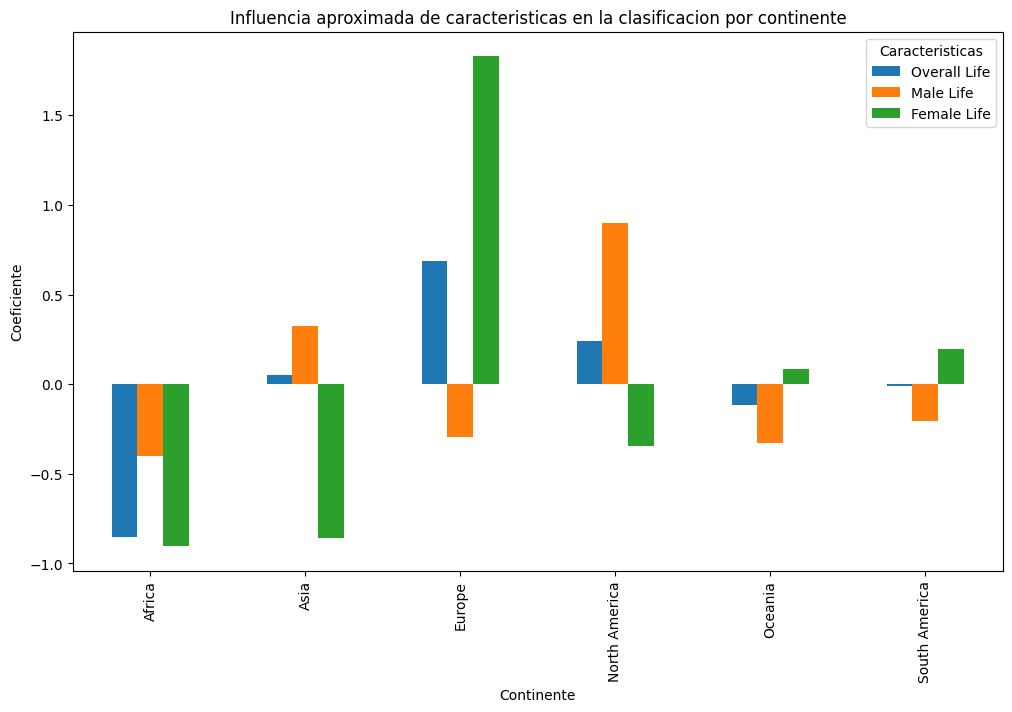


Predicciones de continente para nuevos datos:
Datos 1: Asia
Datos 2: Europe
Datos 3: Africa


In [16]:
import pandas as pd
import io
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import files

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression

# 1. Subir archivo y cargar datos
print("Selecciona el archivo CSV desde tu PC")
uploaded = files.upload()
nombre_archivo = list(uploaded.keys())[0]

df = pd.read_csv(io.BytesIO(uploaded[nombre_archivo]), encoding='latin1')

cols_interes = ['Country', 'Continent', 'Overall Life', 'Male Life', 'Female Life']
df = df[cols_interes].dropna()

# Codificar variable objetivo
le = LabelEncoder()
df['Continent_encoded'] = le.fit_transform(df['Continent'])

print("Mapeo de continentes a etiquetas numericas:")
for c, i in zip(le.classes_, range(len(le.classes_))):
    print(f"{c}: {i}")

# 2. Visualizar datos con pairplot
sns.pairplot(df, vars=['Overall Life', 'Male Life', 'Female Life'], hue='Continent', diag_kind='kde', height=2.5)
plt.suptitle('Distribucion y relacion entre esperanzas de vida por continente', y=1.02)
plt.show()

# 3. Division datos entrenamiento/prueba
X = df[['Overall Life', 'Male Life', 'Female Life']]
y = df['Continent_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 4. Entrenar SVM con kernel RBF y clase balanceada
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced', random_state=42)
svm_model.fit(X_train, y_train)

# 5. Evaluar modelo
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nPrecision del modelo: {accuracy:.2f}")

print("\nReporte de Clasificacion:\n", classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0))

# 6. Matriz de confusion
cm = confusion_matrix(y_test, y_pred, labels=range(len(le.classes_)))

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Prediccion")
plt.ylabel("Real")
plt.title("Matriz de Confusion")
plt.show()

# Promedio de esperanza de vida por continente (ordenado de mayor a menor)
promedios_vida = df.groupby('Continent')[['Overall Life', 'Male Life', 'Female Life']].mean().sort_values('Overall Life', ascending=False)
print("\nPromedio de esperanza de vida por continente (de mayor a menor):")
display(promedios_vida)

# Graficos de barras para esperanza de vida general, masculina y femenina
plt.figure(figsize=(10,6))
sns.barplot(x=promedios_vida.index, y=promedios_vida['Overall Life'])
plt.title('Esperanza de vida general promedio por continente')
plt.ylabel('Esperanza de vida promedio')
plt.xlabel('Continente')
plt.show()

plt.figure(figsize=(10,6))
sns.barplot(x=promedios_vida.index, y=promedios_vida['Male Life'])
plt.title('Esperanza de vida masculina promedio por continente')
plt.ylabel('Esperanza de vida hombres promedio')
plt.xlabel('Continente')
plt.show()

plt.figure(figsize=(10,6))
sns.barplot(x=promedios_vida.index, y=promedios_vida['Female Life'])
plt.title('Esperanza de vida femenina promedio por continente')
plt.ylabel('Esperanza de vida mujeres promedio')
plt.xlabel('Continente')
plt.show()

# Caracteristicas mas influyentes (regresion logistica con escalado para evitar warnings)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

lr = LogisticRegression(max_iter=2000)
lr.fit(X_train_scaled, y_train)

coef_df = pd.DataFrame(lr.coef_, columns=X.columns, index=le.classes_)
print("\nCoeficientes del modelo logistico (influencia aproximada):")
display(coef_df)

coef_df.plot(kind='bar', figsize=(12,7))
plt.title('Influencia aproximada de caracteristicas en la clasificacion por continente')
plt.ylabel('Coeficiente')
plt.xlabel('Continente')
plt.legend(title='Caracteristicas')
plt.show()

# 7. Predicciones con datos nuevos (ejemplo)
nuevos_datos = pd.DataFrame({
    'Overall Life': [70, 82, 60],
    'Male Life': [68, 80, 58],
    'Female Life': [72, 85, 62]
})

predicciones = svm_model.predict(nuevos_datos)
predicciones_continentes = le.inverse_transform(predicciones)

print("\nPredicciones de continente para nuevos datos:")
for i, pred in enumerate(predicciones_continentes):
    print(f"Datos {i+1}: {pred}")
